<a href="https://colab.research.google.com/github/udayameister/Multimodel_GNN/blob/main/GNN_Sample_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 56.7 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
import nibabel as nib
from nilearn import image, masking, plotting
from nilearn.input_data import NiftiMasker

# Load the fMRI data
fmri_path = '/content/sub-01_task-flanker_run-1_bold.nii'
fmri_img = nib.load(fmri_path)

# Perform basic preprocessing (masking and smoothing)
masker = NiftiMasker(smoothing_fwhm=6, standardize=True)
fmri_preprocessed = masker.fit_transform(fmri_img)

# Save the preprocessed data (optional)
preprocessed_img = masker.inverse_transform(fmri_preprocessed)
preprocessed_img.to_filename('preprocessed_fmri.nii')


In [5]:
from nilearn.datasets import fetch_atlas_aal
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

# Fetch the AAL atlas
aal_atlas = fetch_atlas_aal()
atlas_filename = aal_atlas.maps

# Extract time series using the AAL atlas
masker = NiftiLabelsMasker(labels_img=atlas_filename, standardize=True)
time_series = masker.fit_transform(fmri_img)

# Compute the connectivity matrix
correlation_measure = ConnectivityMeasure(kind='correlation')
connectivity_matrix = correlation_measure.fit_transform([time_series])[0]

# Save the connectivity matrix (optional)
np.savetxt('connectivity_matrix.csv', connectivity_matrix, delimiter=',')



Added README.md to /root/nilearn_data


Dataset created in /root/nilearn_data/aal_SPM12



 ...done. (2 seconds, 0 min)
Extracting data from /root/nilearn_data/aal_SPM12/a4f2a6316ec7f29f771edef840308edf/aal_for_SPM12.tar.gz..... done.


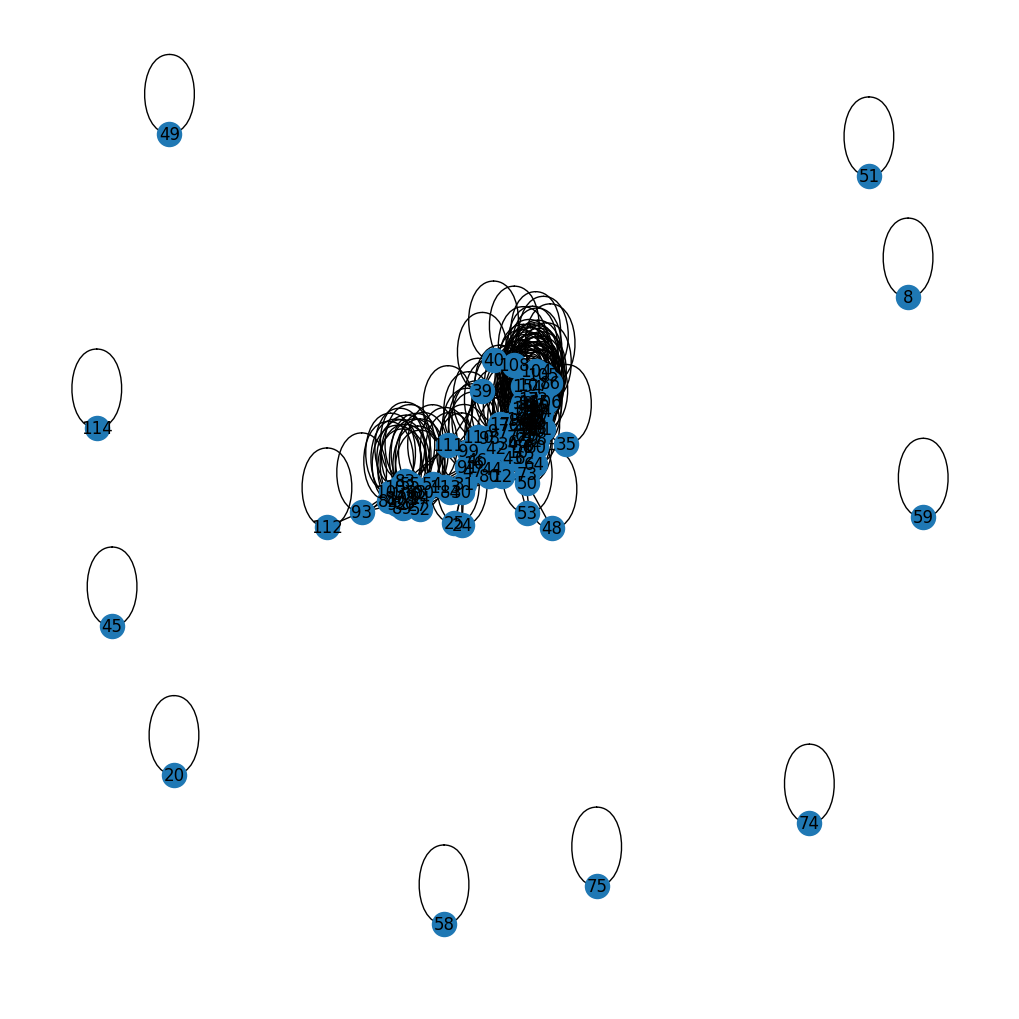

In [8]:
import networkx as nx  # Make sure you are importing networkx correctly
import matplotlib.pyplot as plt

# Create a graph from the connectivity matrix
threshold = 0.5  # Threshold for connectivity
graph = nx.from_numpy_array((connectivity_matrix > threshold).astype(int)) # Use from_numpy_array

# Plot the graph (optional)
plt.figure(figsize=(10, 10))
nx.draw(graph, with_labels=True)
plt.show()

In [10]:
!pip install torch-geometric
import torch
from torch_geometric.data import Data

# Convert the connectivity matrix to edge list format
edge_index = np.array(list(graph.edges)).T

# Create a PyTorch Geometric Data object
x = torch.tensor(connectivity_matrix, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long)
data = Data(x=x, edge_index=edge_index)

# If you have node features, add them to 'data' as 'data.x'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00


In [14]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Instantiate the model, optimizer, and loss function
num_features = data.num_features
num_classes = 2  # AD vs NC
model = GCN(num_features, num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# **Create a tensor for your labels (replace with your actual labels)**
# Assuming you have a list of labels y_list
# Ensure that y_list has a label for EACH NODE in your graph
y_list = [0, 1, 0, 0, 1]  + [0] * (data.num_nodes - 5) # Pad with labels for remaining nodes, assuming they are class 0
data.y = torch.tensor(y_list, dtype=torch.long)

# Train the model
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out, data.y) # data.y should now have the labels
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.3876209557056427
Epoch 2, Loss: 0.1874590814113617
Epoch 3, Loss: 0.12284901738166809
Epoch 4, Loss: 0.12259098887443542
Epoch 5, Loss: 0.13254225254058838
Epoch 6, Loss: 0.11252836883068085
Epoch 7, Loss: 0.09923256933689117
Epoch 8, Loss: 0.1364501267671585
Epoch 9, Loss: 0.11802833527326584
Epoch 10, Loss: 0.13320903480052948
Epoch 11, Loss: 0.09811881184577942
Epoch 12, Loss: 0.10485215485095978
Epoch 13, Loss: 0.09292595833539963
Epoch 14, Loss: 0.12537606060504913
Epoch 15, Loss: 0.1109212189912796
Epoch 16, Loss: 0.10032758861780167
Epoch 17, Loss: 0.09172716736793518
Epoch 18, Loss: 0.09344872832298279
Epoch 19, Loss: 0.10177473723888397
Epoch 20, Loss: 0.13420341908931732
Epoch 21, Loss: 0.09410698711872101
Epoch 22, Loss: 0.06241048872470856
Epoch 23, Loss: 0.10500486195087433
Epoch 24, Loss: 0.07388900220394135
Epoch 25, Loss: 0.08199336379766464
Epoch 26, Loss: 0.08458362519741058
Epoch 27, Loss: 0.06930628418922424
Epoch 28, Loss: 0.08744732290506363
Epoch

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

model.eval()
_, pred = model(data).max(dim=1)
accuracy = accuracy_score(data.y, pred)
auroc = roc_auc_score(data.y, pred)
f1 = f1_score(data.y, pred)

print(f'Accuracy: {accuracy}')
print(f'AUROC: {auroc}')
print(f'F1 Score: {f1}')


Accuracy: 0.9913793103448276
AUROC: 0.75
F1 Score: 0.6666666666666666
